# 00. Dataset Preprocessing

The code in this Jupyter Notebook focuses on preprocessing the collected audio files. It merges all the individual original audio files into a single audio file, adjusting the number of channels, sample rate, and bit depth to meet the desired specifications for model training.

*This step can be skipped if you wish to proceed directly to model training or audio generation. For detailed instructions, refer to '00-download-dataset-and-models.ipynb'.*

In [13]:
import os
from pydub import AudioSegment
import numpy as np
import librosa as li
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from math import ceil
from scipy.fft import fft
from scipy import signal

## Merge Multiple Audio Files into One

Here mostly using [PyDub](https://pypi.org/project/pydub/) - a popular python library for manipulating audio data to conduct audio preprocessing.

Merged Audio:
- Piano Dataset: 6:00:35, sample rate = 48000; number of channels = 2; bit depth = 16
- Techno Dataset: 6:40:32, sample rate = 48000; number of channels = 2; bit depth = 16

Target Audio Specification for Model Training:
- num_channels = 1 (for better exporting, current RAVE version has a problem exporting stereo tracks)
- bit_depth = 16
- sample_rate = 44100


In [14]:
# go to '00-download-dataset-and-models.ipynb' and download corresponding audio files first
piano_mp3_directory = "./sounds/all_piano"
techno_mp3_directory = "./sounds/all_techno"

In [15]:
# create empty audio file - piano & techno, 0 seconds long
# alternatively - AudioSegment.silent(duration=0)
# can also be used to create silent chunck
# reference code: https://stackoverflow.com/questions/45526996/split-audio-files-using-silence-detection
merged_piano_mp3 = AudioSegment.empty()
merged_techno_mp3 = AudioSegment.empty()

# create a list contains all the target audio files
# all files are in mp3, if not, using if file.endswith(".mp3") or convert music format first
piano_files = [file for file in os.listdir(piano_mp3_directory)]
techno_files = [file for file in os.listdir(techno_mp3_directory)]

In [16]:
# merge audio files - piano, it will take a while if there are lots of audio files (about 5mins for piano dataset)
# reference code: https://www.geeksforgeeks.org/how-to-concatenate-audio-files-in-python/
for audio in piano_files:
    mp3_path = os.path.join(piano_mp3_directory, audio)
    audio_segment = AudioSegment.from_mp3(mp3_path)
    merged_piano_mp3 += audio_segment
merged_piano_mp3.export("sounds/preprocessed_audio/merged-piano-dataset.mp3", format="mp3")

<_io.BufferedRandom name='sounds/preprocessed_audio/merged-piano-dataset.mp3'>

In [17]:
# merge audio files - techno (about 5mins for piano dataset)
for audio in techno_files:
    mp3_path = os.path.join(techno_mp3_directory, audio)
    audio_segment = AudioSegment.from_mp3(mp3_path)
    merged_techno_mp3 += audio_segment
merged_techno_mp3.export("sounds/preprocessed_audio/merged-techno-dataset.mp3", format="mp3")

<_io.BufferedRandom name='sounds/preprocessed_audio/merged-techno-dataset.mp3'>

In [18]:
# check the sample rate, number of channels, and bit depth of the merged file
# reference code: https://rizdelhi.medium.com/read-audio-data-in-python-5b761312b4b3
piano_audio = AudioSegment.from_file("sounds/preprocessed_audio/merged-piano-dataset.mp3", format="mp3")
techno_audio = AudioSegment.from_file("sounds/preprocessed_audio/merged-techno-dataset.mp3", format="mp3")

piano_sample_rate = piano_audio.frame_rate
piano_num_channels = piano_audio.channels
piano_bit_depth = piano_audio.sample_width * 8
techno_sample_rate = piano_audio.frame_rate
techno_num_channels = piano_audio.channels
techno_bit_depth = piano_audio.sample_width * 8

print(f"piano dataset - sample rate = {piano_sample_rate}; number of channels = {piano_num_channels}; bit depth = {piano_bit_depth}")
print(f"techno dataset - sample rate = {techno_sample_rate}; number of channels = {techno_num_channels}; bit depth = {techno_bit_depth}")

piano dataset - sample rate = 48000; number of channels = 2; bit depth = 16
techno dataset - sample rate = 48000; number of channels = 2; bit depth = 16


In [19]:
# both has the same bit depth = 16
# change num_channel = 1, set sample rate = 44100
updated_piano_audio = piano_audio.set_frame_rate(44100)
updated_piano_audio = piano_audio.set_channels(1)
updated_piano_audio.export("sounds/preprocessed_audio/processed-merged-piano-dataset.mp3", format="mp3")

<_io.BufferedRandom name='sounds/preprocessed_audio/processed-merged-piano-dataset.mp3'>

In [20]:
updated_techno_audio = techno_audio.set_frame_rate(44100)
updated_techno_audio = techno_audio.set_channels(1)
updated_techno_audio.export("sounds/preprocessed_audio/processed-merged-techno-dataset.mp3", format="mp3")

<_io.BufferedRandom name='sounds/preprocessed_audio/processed-merged-techno-dataset.mp3'>

## Normalisation

RAVE automatically clips the audio if its amplitude is outside the range of -1 to 1, to avoid a loss of information, normalise the merged audio to the range of -1 to 1 if needed.

- the amplitude of the piano dataset is within the range of -1 to 1.
- the amplitude of the techno dataset is outside the range, so normalisation is needed.

In [24]:
# check the amplitude and normalise it to -1 to 1 range if needed
# reference code: # https://stackoverflow.com/questions/65160046/librosa-does-not-normalize-wave-file-between-1-1
# 0.9205545, -0.9236028 - not needed for piano dataset
y, sr = li.load("sounds/preprocessed_audio/processed-merged-piano-dataset.mp3", sr=None)
y_max_actual = y.max()
y_min_actual = y.min()
print(y_max_actual)
print(y_min_actual)

0.9205545
-0.9236028


In [25]:
# check the amplitude and normalise it to -1 to 1 range if needed
# 1.2796514, -1.232465 - normolisation needed for techno dataset
y, sr = li.load("sounds/preprocessed_audio/processed-merged-techno-dataset.mp3", sr=None)
# y = audio time series, sr = sampling rate of y
# reference code: https://librosa.org/doc/main/generated/librosa.load.html
y_max_actual = y.max()
y_min_actual = y.min()
print(y_max_actual)
print(y_min_actual)

1.2796514
-1.232465


In [26]:
max_abs_value = max(abs(y_max_actual), abs(y_min_actual))
max_abs_value = ceil(max_abs_value*10)/10
max_abs_value

1.3

In [27]:
# 1.3 doesnt normalise audio to -1 to 1 (1.0122268, -1.0218902), slightly modify the number 
# alter the number based on the dataset
y_normalized = y / 1.37
sf.write("sounds/preprocessed_audio/normalised-techno-dataset.mp3", y_normalized, sr)

In [28]:
# check the amplitude of the normaliased audio
y, sr = li.load("sounds/preprocessed_audio/normalised-techno-dataset.mp3", sr=None)
y_max_actual = y.max()
y_min_actual = y.min()
print(y_max_actual)
print(y_min_actual)

0.9518482
-0.97373843


In [30]:
# rename processed audio dataset
# reference code: https://www.geeksforgeeks.org/python-os-rename-method/
current_file_path_piano = "sounds/preprocessed_audio/processed-merged-piano-dataset.mp3"
new_file_path_piano = "sounds/preprocessed_audio/piano-dataset.mp3"

current_file_path_techno = "sounds/preprocessed_audio/normalised-techno-dataset.mp3"
new_file_path_techno = "sounds/preprocessed_audio/techno-dataset.mp3"

os.rename(current_file_path_piano, new_file_path_piano)
os.rename(current_file_path_techno, new_file_path_techno)

In [31]:
# remove previous version of audio datasets, only kept the final version
!rm sounds/preprocessed_audio/merged-piano-dataset.mp3
!rm sounds/preprocessed_audio/merged-techno-dataset.mp3
!rm sounds/preprocessed_audio/processed-merged-techno-dataset.mp3

rm: sounds/preprocessed_audio/merged-piano-dataset.mp3: No such file or directory


## Load piano-dataset

code obtained from lecture notebook - week 6b audio generation

/var/folders/w6/m517rm557tzcc05y2_zq5dcc0000gn/T/ipykernel_13964/2282210600.py:8: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  total_duration = li.get_duration(filename=input_file)


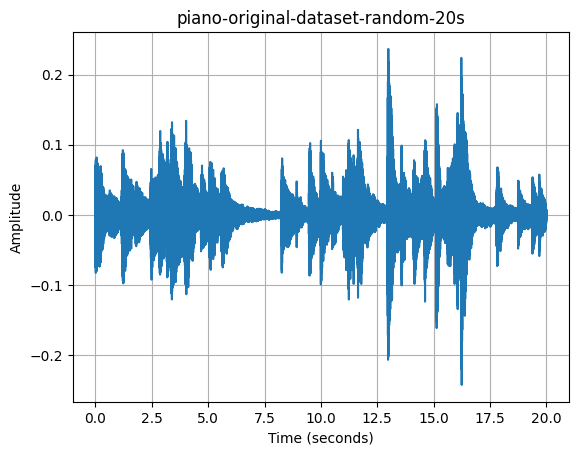

In [49]:
input_file = "sounds/preprocessed_audio/piano-dataset.mp3"
sample_rate = 44100

# #load the first 20 seconds of the audio
# input_data, _ = li.load(input_file, sr=sample_rate, duration=20.0)

# load a random 20-second slice of the audio - code from ChatGPT
total_duration = li.get_duration(filename=input_file)
start_time = np.random.uniform(low=0.0, high=total_duration - 20.0)
input_data, _ = li.load(input_file, sr=sample_rate, offset=start_time, duration=20.0)

# plot the audio waveform
time = np.arange(0, len(input_data)) / sample_rate
plt.plot(time, input_data)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("piano-original-dataset-random-20s")
plt.grid()
plt.show()

# display audio widget
ipd.display(ipd.Audio(data=input_data, rate=sample_rate))

/var/folders/w6/m517rm557tzcc05y2_zq5dcc0000gn/T/ipykernel_13964/740650058.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100, :],


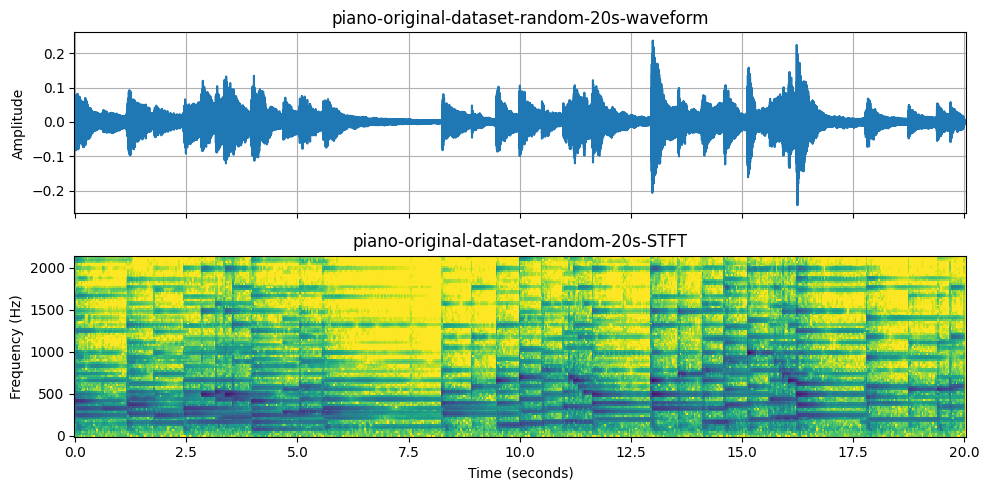

In [52]:
f1, t1, Zxx1 = signal.stft(input_data, fs=sample_rate, nperseg=2048, noverlap=512)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

axs[0].plot(time, input_data)
axs[0].set_ylabel("Amplitude")
axs[0].grid()
axs[0].set_title("piano-original-dataset-random-20s-waveform")

axs[1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100, :],
                                                       ref=np.max)))
axs[1].set_xlabel("Time (seconds)")
axs[1].set_title("piano-original-dataset-random-20s-STFT")
axs[1].set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

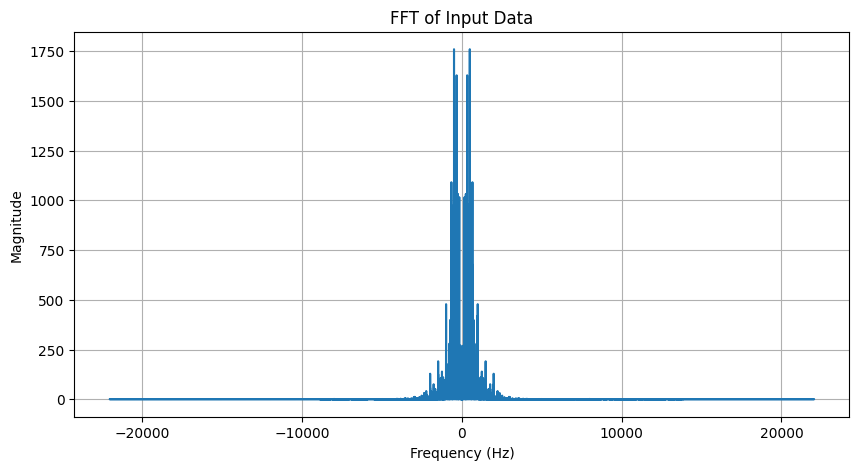

In [53]:
# Compute FFT
fft_output = fft(input_data)

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_output)

# Frequency axis
frequency = np.fft.fftfreq(len(input_data), d=1/sample_rate)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(frequency, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Input Data')
plt.grid()
plt.show()

## Load techno-dataset

/var/folders/w6/m517rm557tzcc05y2_zq5dcc0000gn/T/ipykernel_13964/243747518.py:8: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  total_duration = li.get_duration(filename=input_file)


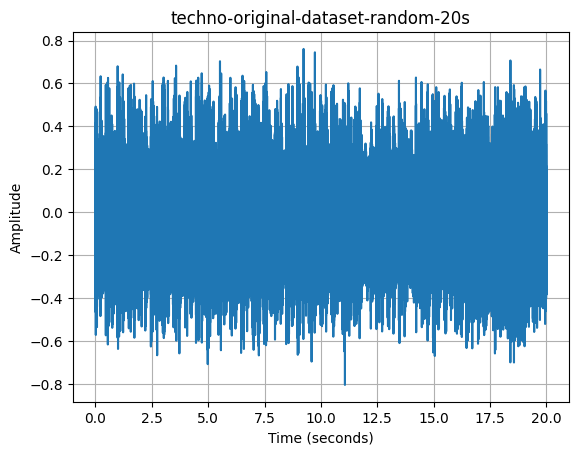

In [61]:
input_file = "sounds/preprocessed_audio/techno-dataset.mp3"
sample_rate = 44100

# # load the first 30 seconds of the audio
# input_data, _ = li.load(input_file, sr=sample_rate, duration=20.0)

# load a random 20-second slice of the audio - code from ChatGPT
total_duration = li.get_duration(filename=input_file)
start_time = np.random.uniform(low=0.0, high=total_duration - 20.0)
input_data, _ = li.load(input_file, sr=sample_rate, offset=start_time, duration=20.0)

# plot the audio waveform
time = np.arange(0, len(input_data)) / sample_rate
plt.plot(time, input_data)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title("techno-original-dataset-random-20s")
plt.grid()
plt.show()

# display audio widget
ipd.display(ipd.Audio(data=input_data, rate=sample_rate))

/var/folders/w6/m517rm557tzcc05y2_zq5dcc0000gn/T/ipykernel_13964/997466682.py:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100, :],


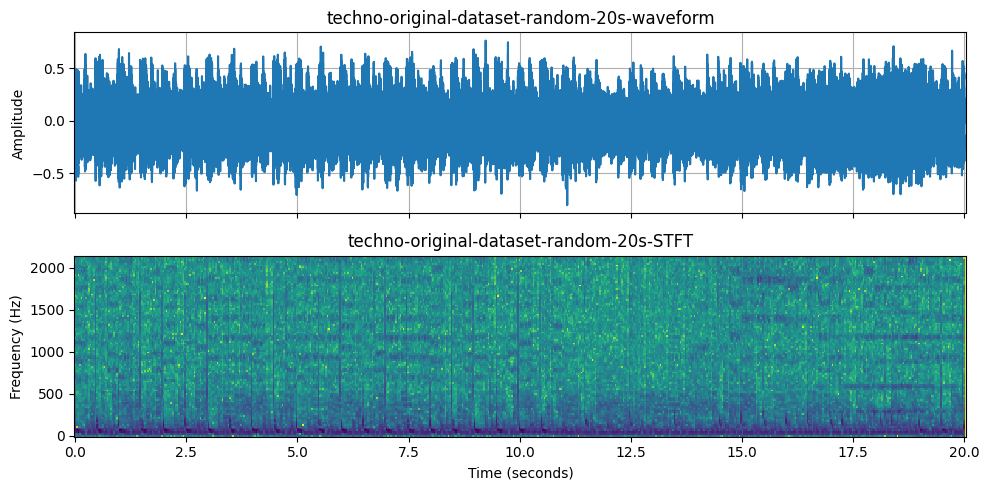

In [62]:
f1, t1, Zxx1 = signal.stft(input_data, fs=sample_rate, nperseg=2048, noverlap=512)

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

axs[0].plot(time, input_data)
axs[0].set_ylabel("Amplitude")
axs[0].grid()
axs[0].set_title("techno-original-dataset-random-20s-waveform")

axs[1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100, :],
                                                       ref=np.max)))
axs[1].set_xlabel("Time (seconds)")
axs[1].set_title("techno-original-dataset-random-20s-STFT")
axs[1].set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

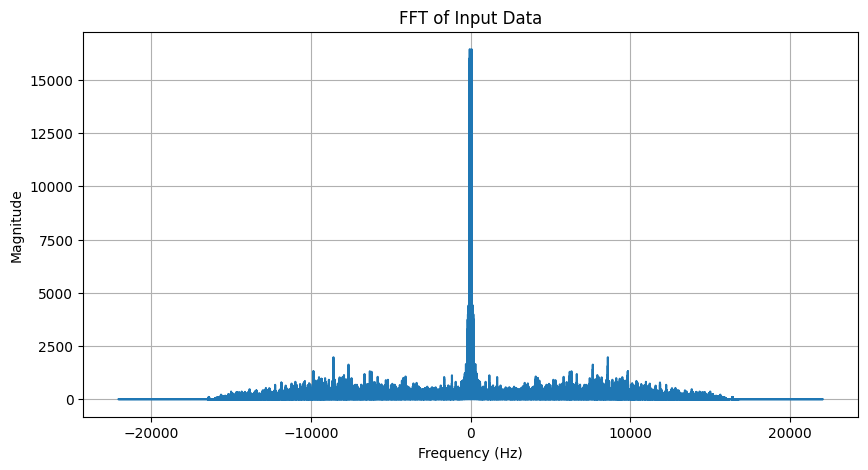

In [63]:
# Compute FFT
fft_output = fft(input_data)

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(fft_output)

# Frequency axis
frequency = np.fft.fftfreq(len(input_data), d=1/sample_rate)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(frequency, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Input Data')
plt.grid()
plt.show()